Introduccion redes bayesianas, referencias:

- https://www.coursera.org/lecture/razonamiento-artificial/redes-bayesianas-ajdnx
- https://docs.pymc.io/index.html
- https://relopezbriega.github.io/blog/2017/05/21/introduccion-a-la-inferencia-bayesiana-con-python/
- http://lcc.uma.es/~eva/aic/Redes%20Bayesianas.pdf

# El problema de la moneda

Los problemas de monedas son clásicos cuando hablamos de probabilidad y estadística, nos permiten ejemplificar conceptos abstractos de forma simple. Asimismo, pueden ser muchas veces conceptualmente similares a situaciones reales, de hecho cualquier problema en donde obtengamos resultados binarios, 0/1, enfermo/sano, spam/no-spam, puede ser pensado como si estuviéramos hablando de monedas. En este caso, la idea es utilizar un modelo bayesiano para inferir si la moneda se encuentra sesgada o no.

Para este ejemplo, vamos a utilizar una distribución binomial como likelihood y una distribución beta como a priori. Veamos como lo podemos modelar con PyMC3.

In [53]:
# El problema de la moneda
# de 100 lanzamientos 80 caras
n = 100
caras = 80

In [54]:
# Creación del modelo
niter = 2000
with pm.Model() as modelo_moneda:
    # a priori
    p = pm.Beta('p', alpha=2, beta=2)  # https://es.wikipedia.org/wiki/Distribuci%C3%B3n_beta
    # likelihood
    y = pm.Binomial('y', n=n, p=p, observed=caras)  # https://es.wikipedia.org/wiki/Distribuci%C3%B3n_binomial

In [55]:
# Realizando el muestreo para la inferencia
with modelo_moneda:
    trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:01<00:00, 4622.99draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62cf5c8898>,
      dtype=object)

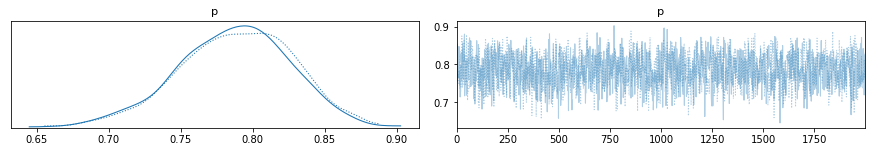

In [56]:
# Analizando los resultados
pm.traceplot(trace, var_names=['p'])

In [57]:
# Información resumen. 
#Vemos que hay un 95% de probabilidades de que el valor de sesgo este entre
# .706 y .864
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.787,0.039,0.708,0.857,0.001,0.001,1672.0,1652.0,1650.0,2529.0,1.0


### Como vemos el modelo nos indica que la moneda parece tener un claro sesgo hacia cara.

# El problema de la hierba humeda

<img src="pics/Red_Bayesiana_Simple.png">

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm

ModuleNotFoundError: No module named 'pymc3'

In [59]:
# Problema de la hierba mojada
# https://es.wikipedia.org/wiki/Red_bayesiana#Ejemplo
niter = 10000  # 10000
tune = 5000  # 5000

modelo = pm.Model()

with modelo:
    tv = [1]
    lluvia = pm.Bernoulli('lluvia', 0.2, shape=1, testval=tv)
    rociador_p = pm.Deterministic('rociador_p', 
                                  pm.math.switch(lluvia, 0.01, 0.40))
    rociador = pm.Bernoulli('rociador', rociador_p, shape=1, testval=tv)
    hierba_mojada_p = pm.Deterministic('hierba_mojada_p', 
                pm.math.switch(lluvia, pm.math.switch(rociador, 0.99, 0.80),
                               pm.math.switch(rociador, 0.90, 0.0)))
    hierba_mojada = pm.Bernoulli('hierba_mojada', hierba_mojada_p,
                             observed=np.array([1]), shape=1)

    trace = pm.sample(20000, 
                      step=[pm.BinaryGibbsMetropolis([lluvia, rociador])], 
                      tune=tune, random_seed=124)

# pm.traceplot(trace)

dictionary = {
              'lluvia': [1 if ii[0] else 0 for ii in trace['lluvia'].tolist() ],
              'rociador': [1 if ii[0] else 0 for ii in trace['rociador'].tolist() ],
              'rociador_p': [ii[0] for ii in trace['rociador_p'].tolist()],
              'hierba_mojada_p': [ii[0] for ii in trace['hierba_mojada_p'].tolist()],
              }
df = pd.DataFrame(dictionary)

p_lluvia = df[(df['lluvia'] == 1)].shape[0] / df.shape[0]
print("\nProbabilidad de que la hierba este mojada por la lluvia: {0}"
      .format(p_lluvia))

p_rociador = df[(df['rociador'] == 1)].shape[0] / df.shape[0]
print("Probabilidad de que la hierba este mojada por el rociador: {0}"
      .format(p_rociador))

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [lluvia, rociador]
Sampling 2 chains, 0 divergences: 100%|██████████| 50000/50000 [00:03<00:00, 13186.00draws/s]
The number of effective samples is smaller than 10% for some parameters.



Probabilidad de que la hierba este mojada por la lluvia: 0.358975
Probabilidad de que la hierba este mojada por el rociador: 0.646075
